# Approximating time-dependent surface displacements (from Relax) with an array of basal dislocations

In [1]:
import glob
import gmsh
import meshio
import pygmt
import matplotlib 
import scipy
from matplotlib import pyplot as plt
from scipy.interpolate import RBFInterpolator
from ismember import ismember

import cutde.halfspace as cutde_halfspace
import numpy as np
import pandas as pd
import xarray as xa
import addict
import celeri

%config InlineBackend.figure_format = "retina"

# Utility functions

In [2]:
# Plot a single mesh; modified from celeri_vis.py
def plot_mesh(mesh, fill_value, ax):
    x_coords = mesh.coords[:, 0]
    y_coords = mesh.coords[:, 1]
    vertex_array = np.asarray(mesh.verts)

    if not ax:
        ax = plt.gca()
        
    xy = np.c_[x_coords, y_coords]
    verts = xy[vertex_array]
    pc = matplotlib.collections.PolyCollection(
        verts, edgecolor="none", cmap="rainbow"
    )
    pc.set_array(fill_value)
    ax.add_collection(pc)
    ax.autoscale()
    # pc.set_clim([-0.001, 0.001])
    plt.colorbar(pc, label=" ")

## File locations

In [3]:
directory = "./tutorials/output2/"
pathname = directory + "000-north.grd"
grid = pygmt.load_dataarray(pathname)

## Set up triangular dislocation sources

In [4]:
def tri_horizon(x, y, z, el_size):
    # Makes a simple ~horizon of triangular dislocation elements using Gmsh
    # x, y are 2-element arrays defining horizontal bounds
    # z is a scalar giving depth
    # el_size gives nominal element size

    # Mesh construction using Gmsh
    gmsh.initialize()

    # Define points
    gmsh.model.geo.addPoint(x[0], y[0], z + 0.01, el_size, 1)
    gmsh.model.geo.addPoint(x[1], y[0], z - 0.01, el_size, 2)
    gmsh.model.geo.addPoint(x[1], y[1], z - 0.01, el_size, 3)
    gmsh.model.geo.addPoint(x[0], y[1], z + 0.01, el_size, 4)

    # Boundary lines
    gmsh.model.geo.addLine(1, 2, 1)
    gmsh.model.geo.addLine(2, 3, 2)
    gmsh.model.geo.addLine(3, 4, 3)
    gmsh.model.geo.addLine(4, 1, 4)

    # Perimeter
    gmsh.model.geo.addCurveLoop([1, 2, 3, 4], 1)

    # Surface
    gmsh.model.geo.addPlaneSurface([1], 1)
    gmsh.model.geo.synchronize()

    # Generate and write. Writing a file allows use of meshio, consistent with celeri codes
    gmsh.model.mesh.generate(2)
    gmsh.write("file.msh")
    gmsh.finalize()

    # Read and parse mesh
    mesh = meshio.read("file.msh")
    fault_pts = mesh.points
    fault_tri = meshio.CellBlock("triangle", mesh.get_cells_type("triangle")).data
    return fault_pts, fault_tri


## Define source mesh and horizon, calculate partials

In [5]:
# Get stations from grid plotted above
gsubset = 10  # Subset of grid points: increment every gsubset points along grid
xg = np.array(grid.x)
yg = np.array(grid.y)
Xg, Yg = np.meshgrid(xg, yg)
obsg = (
    np.array(
        [
            Xg[0::gsubset, 0::gsubset],
            Yg[0::gsubset, 0::gsubset],
            0 * Yg[0::gsubset, 0::gsubset],
        ]
    )
    .reshape((3, -1))
    .T.copy()
)

# Define source fault
meshes = []
# Define horizontal mesh
meshes.append(addict.Dict())
# meshes[0].coords, meshes[0].verts = tri_horizon([-10, 10], [-10, 10], -2, 1)
meshes[0].coords, meshes[0].verts = tri_horizon([-7, 7], [-7, 7], -2, 1)

nsource_tri = 0
nhoriz_tri = np.shape(meshes[0].verts)[0]
ntri = nsource_tri + nhoriz_tri

# Concatenate source and horizontal
horiz_tri_pts = meshes[0].coords[meshes[0].verts]
all_tri_pts = np.copy(horiz_tri_pts)

# Calculate element normals, strike and dip
meshes[0].normal_vector = np.cross(
    horiz_tri_pts[:, 1, :] - horiz_tri_pts[:, 0, :],
    horiz_tri_pts[:, 2, :] - horiz_tri_pts[:, 0, :],
)

# Calculate TDE partials for the subset array
disp_mat = cutde_halfspace.disp_matrix(obs_pts=obsg, tris=all_tri_pts, nu=0.25)

# Calculate TDE partials for the full array, for comparison with full Relax grid
obsg_full = np.array([Xg, Yg, 0 * Yg]).reshape((3, -1)).T.copy()
disp_mat_full = cutde_halfspace.disp_matrix(
    obs_pts=obsg_full, tris=all_tri_pts, nu=0.25
)


Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 30%] Meshing curve 2 (Line)
Info    : [ 50%] Meshing curve 3 (Line)
Info    : [ 80%] Meshing curve 4 (Line)
Info    : Done meshing 1D (Wall 0.000157833s, CPU 0.000218s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.00364033s, CPU 0.003655s)
Info    : 258 nodes 518 elements
Info    : Writing 'file.msh'...
Info    : Done writing 'file.msh'



# Set up inversion of Relax displacements

## Matrix assembly

In [6]:
# Get triangular smoothing matrix
operators = addict.Dict()
celeri.get_all_mesh_smoothing_matrices_simple(meshes, operators)

# Assemble matrices
assembled_mat = np.zeros((np.size(obsg) + 3 * ntri, 3 * ntri))

# Insert elastic partials
assembled_mat[0 : np.size(obsg), :] = disp_mat.reshape((-1, 3 * ntri))

# Insert smoothing matrices
source_row_start = np.size(obsg)
source_row_end = np.size(obsg) + 3 * nsource_tri
# assembled_mat[
#     source_row_start:source_row_end, 0 : 3 * nsource_tri
# ] = operators.smoothing_matrix[0].toarray()
assembled_mat[source_row_end:, 3 * nsource_tri :] = operators.smoothing_matrix[
    0
].toarray()

# Assemble weighting vector
smoothing_weight = 1e-3
weights = np.ones((np.shape(assembled_mat)[0], 1))
weights[source_row_start:] = smoothing_weight


# Find boundaries and get linear operator for applying boundary conditions

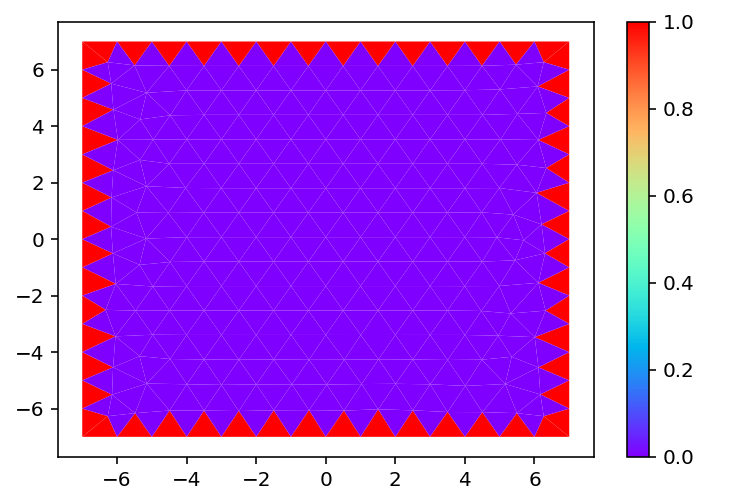

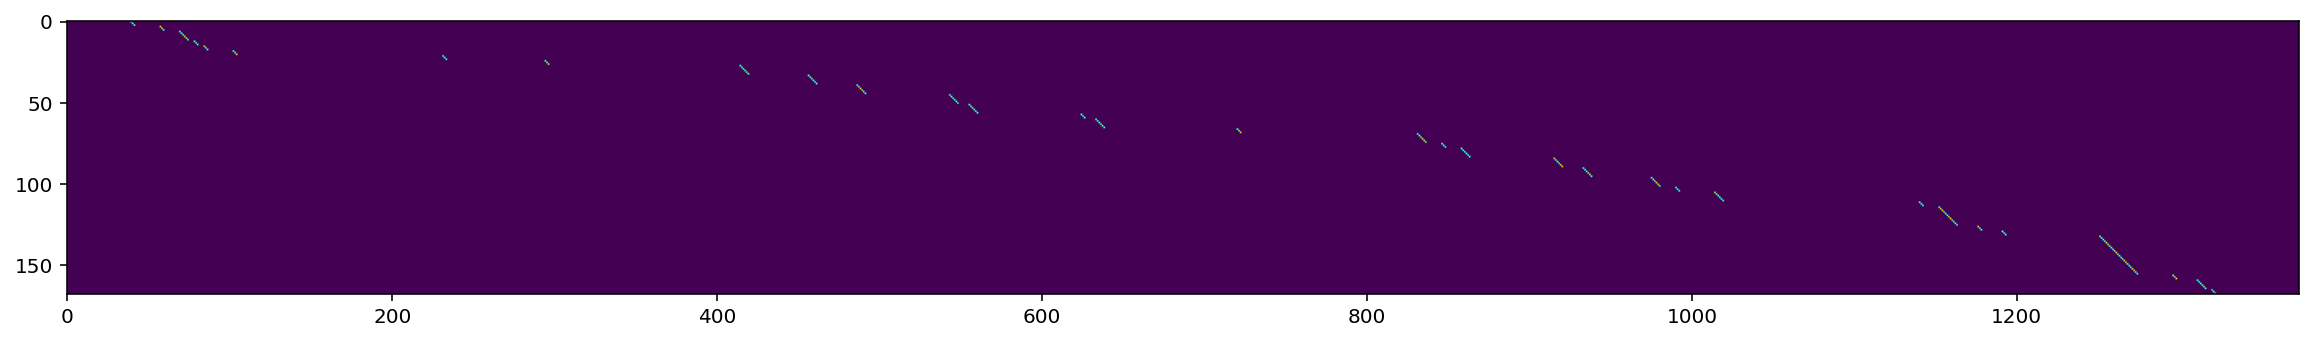

In [7]:
def get_mesh_edge_elements(meshes):
    # Find indices of elements lining top, bottom, and sides of each mesh

    celeri.get_ordered_edge_nodes(meshes)

    for i in range(len(meshes)):
    # for i in range(1, 2):

        # coords = meshes[i].meshio_object.points
        coords = meshes[i].coords

        vertices = meshes[i].verts

        # Arrays of all element side node pairs
        side_1 = np.sort(np.vstack((vertices[:, 0], vertices[:, 1])).T, 1)
        side_2 = np.sort(np.vstack((vertices[:, 1], vertices[:, 2])).T, 1)
        side_3 = np.sort(np.vstack((vertices[:, 2], vertices[:, 0])).T, 1)

        # Sort edge node array
        sorted_edge_nodes = np.sort(meshes[i].ordered_edge_nodes, 1)

        # Indices of element sides that are in edge node array
        side_1_in_edge, side_1_in_edge_idx = ismember(sorted_edge_nodes, side_1, "rows")
        side_2_in_edge, side_2_in_edge_idx = ismember(sorted_edge_nodes, side_2, "rows")
        side_3_in_edge, side_3_in_edge_idx = ismember(sorted_edge_nodes, side_3, "rows")

        # Depths of nodes
        side_1_depths = np.abs(
            coords[
                np.column_stack(
                    (side_1[side_1_in_edge_idx, :], vertices[side_1_in_edge_idx, 2])
                ),
                2,
            ]
        )
        side_2_depths = np.abs(
            coords[
                np.column_stack(
                    (side_2[side_2_in_edge_idx, :], vertices[side_2_in_edge_idx, 0])
                ),
                2,
            ]
        )
        side_3_depths = np.abs(
            coords[
                np.column_stack(
                    (side_3[side_3_in_edge_idx, :], vertices[side_3_in_edge_idx, 1])
                ),
                2,
            ]
        )
        # Top elements are those where the depth difference between the non-edge node
        # and the mean of the edge nodes is greater than the depth difference between
        # the edge nodes themselves
        top1 = (side_1_depths[:, 2] - np.mean(side_1_depths[:, 0:2], 1)) > (
            np.abs(side_1_depths[:, 0] - side_1_depths[:, 1])
        )
        top2 = (side_2_depths[:, 2] - np.mean(side_2_depths[:, 0:2], 1)) > (
            np.abs(side_2_depths[:, 0] - side_2_depths[:, 1])
        )
        top3 = (side_3_depths[:, 2] - np.mean(side_3_depths[:, 0:2], 1)) > (
            np.abs(side_3_depths[:, 0] - side_3_depths[:, 1])
        )
        tops = np.full(len(vertices), False, dtype=bool)
        tops[side_1_in_edge_idx[top1]] = True
        tops[side_2_in_edge_idx[top2]] = True
        tops[side_3_in_edge_idx[top3]] = True
        meshes[i].top_elements = tops

        # Bottom elements are those where the depth difference between the non-edge node
        # and the mean of the edge nodes is more negative than the depth difference between
        # the edge nodes themselves
        bot1 = side_1_depths[:, 2] - np.mean(side_1_depths[:, 0:2], 1) < -np.abs(
            side_1_depths[:, 0] - side_1_depths[:, 1]
        )
        bot2 = side_2_depths[:, 2] - np.mean(side_2_depths[:, 0:2], 1) < -np.abs(
            side_2_depths[:, 0] - side_2_depths[:, 1]
        )
        bot3 = side_3_depths[:, 2] - np.mean(side_3_depths[:, 0:2], 1) < -np.abs(
            side_3_depths[:, 0] - side_3_depths[:, 1]
        )
        bots = np.full(len(vertices), False, dtype=bool)
        bots[side_1_in_edge_idx[bot1]] = True
        bots[side_2_in_edge_idx[bot2]] = True
        bots[side_3_in_edge_idx[bot3]] = True
        meshes[i].bot_elements = bots

        # Side elements are a set difference between all edges and tops, bottoms
        sides = np.full(len(vertices), False, dtype=bool)
        sides[side_1_in_edge_idx] = True
        sides[side_2_in_edge_idx] = True
        sides[side_3_in_edge_idx] = True
        sides[np.where(tops != 0)] = False
        sides[np.where(bots != 0)] = False
        meshes[i].side_elements = sides


def get_tde_slip_rate_constraints_3_component(meshes, operators):
    """Construct TDE slip rate constraint matrices for each mesh.
    These are essentially identity matrices, used to set TDE slip
    rates on elements lining the edges of the mesh, as controlled
    by input parameters
    top_slip_rate_constraint,
    bot_slip_rate_constraint,
    side_slip_rate_constraint

    Args:
        meshes (List): list of mesh dictionaries
        operators (Dict): dictionary of linear operators
    """
    for i in range(len(meshes)):
        # Empty constraint matrix
        tde_slip_rate_constraints = np.zeros((3 * meshes[i].n_tde, 3 * meshes[i].n_tde))
        # Top constraints
        if meshes[i].top_slip_rate_constraint > 0:
            # Indices of top elements
            top_indices = np.asarray(np.where(meshes[i].top_elements))
            # Indices of top elements' 3 slip components
            top_idx = celeri.get_3component_index(top_indices)
            tde_slip_rate_constraints[top_idx, top_idx] = 1
        # Bottom constraints
        if meshes[i].bot_slip_rate_constraint > 0:
            # Indices of bottom elements
            bot_indices = np.asarray(np.where(meshes[i].bot_elements))
            # Indices of bottom elements' 3 slip components
            bot_idx = celeri.get_3component_index(bot_indices)
            tde_slip_rate_constraints[bot_idx, bot_idx] = 1
        # Side constraints
        if meshes[i].side_slip_rate_constraint > 0:
            # Indices of side elements
            side_indices = np.asarray(np.where(meshes[i].side_elements))
            # Indices of side elements' 3 slip components
            side_idx = celeri.get_3component_index(side_indices)
            tde_slip_rate_constraints[side_idx, side_idx] = 1
        # Eliminate blank rows
        sum_constraint_columns = np.sum(tde_slip_rate_constraints, 1)
        tde_slip_rate_constraints = tde_slip_rate_constraints[
            sum_constraint_columns > 0, :
        ]
        operators.tde_slip_rate_constraints[i] = tde_slip_rate_constraints
        meshes[i].n_tde_constraints = np.sum(sum_constraint_columns > 0)


get_mesh_edge_elements(meshes)
edge_elemnt_idx = np.concatenate(
    (
        np.where(meshes[0].top_elements == True)[0],
        np.where(meshes[0].bot_elements == True)[0],
        np.where(meshes[0].side_elements == True)[0],
    )
)
show_edge_mesh = np.zeros(meshes[0].verts.shape[0])
show_edge_mesh[edge_elemnt_idx] = 1
plot_mesh(meshes[0], show_edge_mesh, plt.gca())

for i in range(len(meshes)):
    meshes[i].n_tde = meshes[i].verts.shape[0]

# Set flag for boundary conditons applied to interestign mesh edges
meshes[0].top_slip_rate_constraint = 1
meshes[0].bot_slip_rate_constraint = 1
meshes[0].side_slip_rate_constraint = 1

get_tde_slip_rate_constraints_3_component(meshes, operators)
plt.figure(figsize=(20, 8))
plt.imshow(operators.tde_slip_rate_constraints[0])

# Eigenmode approach

In [8]:
n_eigenvalues = 50

# Copy of TDE to displacememnt matrix
tri_to_disp = np.copy(disp_mat.reshape((-1, 3 * ntri)))

# Find all triangle centroids and calculate centroid to centroid distances
centroid_coordinates = np.mean(all_tri_pts, axis=1)
distance_matrix = scipy.spatial.distance.cdist(
    centroid_coordinates, centroid_coordinates, "euclidean"
)

# Rescale distance matrix to the range 0-1
distance_matrix = (distance_matrix - np.min(distance_matrix)) / np.ptp(distance_matrix)

# Calculate distance "correlation" matrix
correlation_matrix = np.exp(-distance_matrix)

# Calculate eigenvalues and eigenvectors
# https://stackoverflow.com/questions/12167654/fastest-way-to-compute-k-largest-eigenvalues-and-corresponding-eigenvectors-with
n_tde = np.shape(distance_matrix)[0]

eigenvalues, eigenvectors = scipy.linalg.eigh(
    correlation_matrix,
    subset_by_index=[n_tde - n_eigenvalues, n_tde - 1],
)
eigenvalues = np.real(eigenvalues)
eigenvectors = np.real(eigenvectors)
ordered_index = np.flip(np.argsort(eigenvalues))
eigenvalues = eigenvalues[ordered_index]
eigenvectors = eigenvectors[:, ordered_index]

# Normalize eigenvectors so that all range from -0.5 to 0.5
for i in range(n_eigenvalues):
    eigenvectors[:, i] = eigenvectors[:, i] - np.min(eigenvectors[:, i])
    eigenvectors[:, i] = eigenvectors[:, i] / np.max(eigenvectors[:, i])
    eigenvectors[:, i] = eigenvectors[:, i] - 0.5

# Build checkerboard matrix
# Create modified eigenvector matrix here
# This is a replication of the EVs for both slip components
# There are other ways to do this but as implemented is a sort of
# checkerboard like pattern.  The column indexing an every other
# row striding implements this.
eigenvectors_three_component = np.zeros(
    (3 * eigenvectors.shape[0], 3 * eigenvectors.shape[1])
)
for i in range(n_eigenvalues):
    index_column_1 = 3 * i
    index_column_2 = 3 * i + 1
    index_column_3 = 3 * i + 2
    eigenvectors_three_component[0::3, index_column_1] = eigenvectors[:, i]
    eigenvectors_three_component[1::3, index_column_2] = eigenvectors[:, i]
    eigenvectors_three_component[2::3, index_column_3] = eigenvectors[:, i]

# Eigenvectors to displacement operator
eigen_to_disp = tri_to_disp @ eigenvectors_three_component


# Plot clean figure of first 20 eigenmodes

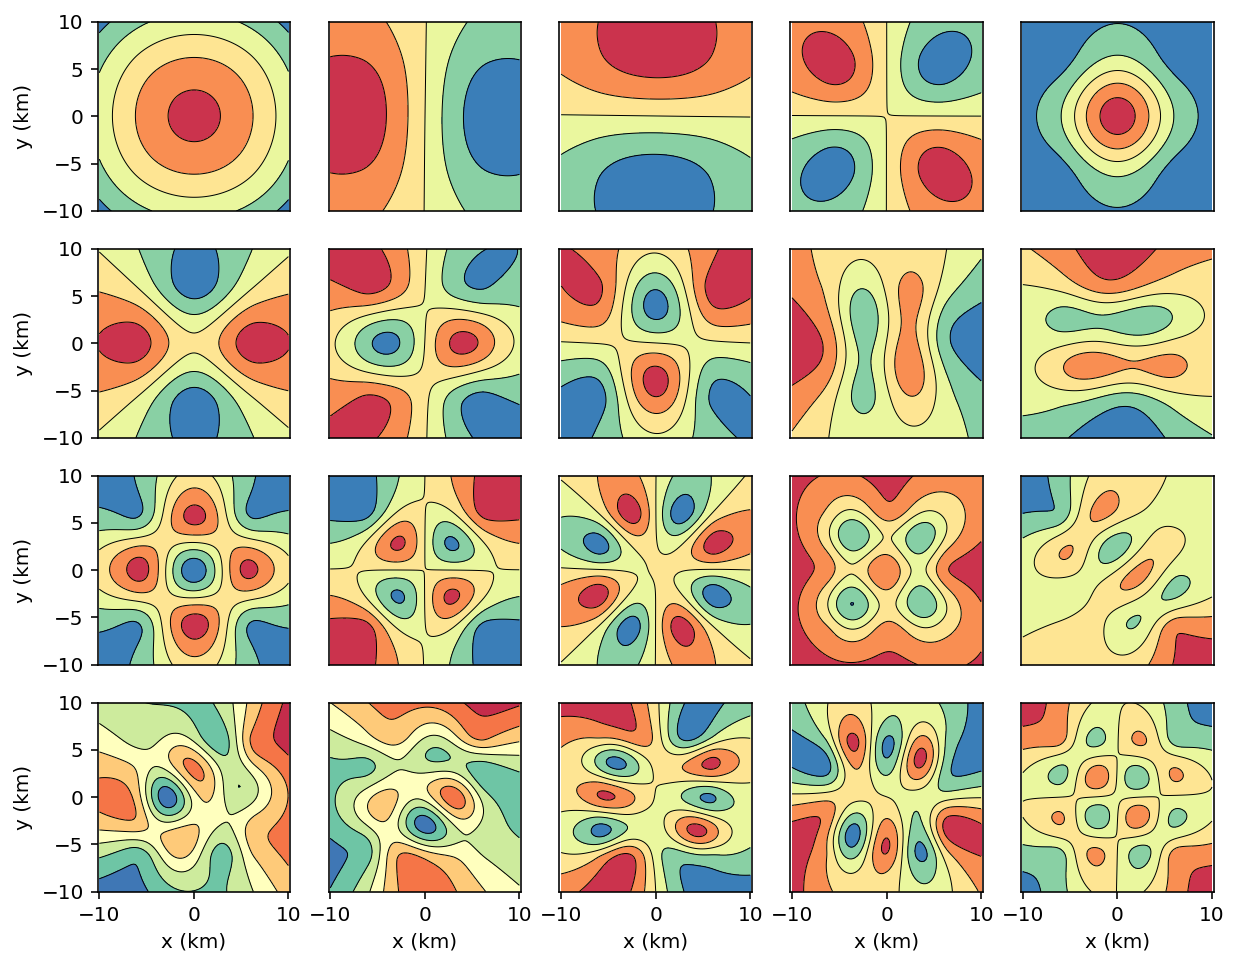

In [9]:
def rbf_interpolate():
    # Observation coordinates and data
    x_vec = np.linspace(-10, 10, 100)
    y_vec = np.linspace(-10, 10, 100)
    x_mat, y_mat = np.meshgrid(x_vec, y_vec)

    centroids_x = centroid_coordinates[:, 0]
    centroids_y = centroid_coordinates[:, 1]
    centroids_val = eigenvectors[:, i]

    # Package for RBFInterpolator
    xgrid = np.stack((x_mat, y_mat))
    xflat = xgrid.reshape(2, -1).T
    xobs = np.vstack((centroids_x, centroids_y)).T
    yobs = centroids_val
    yflat = RBFInterpolator(xobs, yobs, kernel="cubic", smoothing=0.01, epsilon=1.5)(
        xflat
    )
    return xflat, yflat


plt.figure(figsize=(10, 8))
for i in range(20):
    plt.subplot(4, 5, i + 1)
    xflat, yflat = rbf_interpolate()
    x_grid = xflat[:, 0].reshape((100, 100))
    y_grid = xflat[:, 1].reshape((100, 100))
    z_grid = yflat.reshape((100, 100))
    plt.contourf(x_grid, y_grid, z_grid, 5, cmap="Spectral")
    plt.contour(
        x_grid,
        y_grid,
        z_grid,
        colors="k",
        linestyles="solid",
        linewidths=0.5,
        levels=5,
    )
    plt.axis("equal")
    plt.xlim([-10, 10])
    plt.ylim([-10, 10])
    if i in (0, 5, 10):
        plt.xticks([])
        plt.ylabel("y (km)")
    elif i in (16, 17, 18, 19):
        plt.yticks([])
        plt.xlabel("x (km)")
    elif i == 15:
        plt.xlabel("x (km)")
        plt.ylabel("y (km)")
    else:
        plt.xticks([])
        plt.yticks([])
plt.show()


# Sequential reading and inversion of displacement grids

In [10]:
# Read sequence of displacement grd files and invert
e_disp_file_list = sorted(glob.glob(directory + "*-relax-east.grd"))
n_disp_file_list = sorted(glob.glob(directory + "*-relax-north.grd"))
u_disp_file_list = sorted(glob.glob(directory + "*-relax-up.grd"))

# Allocate space for estimated slip and predicted displacements
est_slip = np.zeros((3 * ntri, len(e_disp_file_list)))
est_slip_eigen = np.zeros((3 * ntri, len(e_disp_file_list)))
est_eigen = np.zeros((3 * n_eigenvalues, len(e_disp_file_list)))
pred_disp = np.zeros((obsg_full.size, len(e_disp_file_list)))
pred_disp_bjm = np.zeros((source_row_start, len(e_disp_file_list)))
pred_disp_eigen = np.zeros((source_row_start, len(e_disp_file_list)))
observed_disp = np.zeros((source_row_start, len(e_disp_file_list)))

# Allocate space for data vector
data_vector = np.zeros(source_row_start + 3 * ntri)
data_vector_eigen = np.zeros(source_row_start)
disp_residual_mse = np.zeros(len(e_disp_file_list))
disp_residual_mse_eigen = np.zeros(len(e_disp_file_list))

# Calculate model covariance
cov = np.linalg.inv(assembled_mat.T * weights.T @ assembled_mat)
cov_eigen = np.linalg.inv(eigen_to_disp.T @ eigen_to_disp)

# Read each file and invert
# for i in range(len(e_disp_file_list)):
for i in range(3):

    # Read components
    e_disp = pygmt.load_dataarray(e_disp_file_list[i])
    n_disp = pygmt.load_dataarray(n_disp_file_list[i])
    u_disp = pygmt.load_dataarray(u_disp_file_list[i])

    # Take the same subset as when setting up partials
    disp_array = (
        np.array(
            [
                e_disp[0::gsubset, 0::gsubset],
                n_disp[0::gsubset, 0::gsubset],
                u_disp[0::gsubset, 0::gsubset],
            ]
        )
        .reshape((3, -1))
        .T.copy()
    )
    observed_disp[:, i] = disp_array.flatten()
    data_vector[0:source_row_start] = disp_array.flatten()
    data_vector_eigen[0:source_row_start] = disp_array.flatten()

    # Estimate slip using pre-calculated covariance
    est_slip[:, i] = cov @ assembled_mat.T * weights.T @ data_vector

    # Predict displacement at the full grid resolution
    pred_disp[:, i] = disp_mat_full.reshape((-1, 3 * ntri)).dot(est_slip[:, i])

    # Predicted displacements from classical smoothing approach
    temp = assembled_mat @ est_slip[:, i]
    pred_disp_bjm[:, i] = temp[0:source_row_start]

    disp_residual_mse[i] = np.sum(
        (pred_disp_bjm[:, i] - data_vector[0:source_row_start]) ** 2.0
    ) / source_row_start

    # Eigenvector approach
    est_eigen[:, i] = cov_eigen @ eigen_to_disp.T @ data_vector_eigen

    # Extract TDE slips from state vector
    est_slip_eigen[:, i] = eigenvectors_three_component @ est_eigen[:, i]
    # eigen_tde_strike_slip_rates = eigen_tde_disps[0::3]
    # eigen_tde_dip_slip_rates = eigen_tde_disps[1::3]
    # eigen_tde_tensile_slip_rates = eigen_tde_disps[2::3]

    # Calculate residuals from estimated eigenmodes
    pred_disp_eigen[:, i] = eigen_to_disp @ est_eigen[:, i]
    disp_residual_mse_eigen[i] = np.sum(
        (pred_disp_eigen[:, i] - data_vector_eigen) ** 2.0
    ) / len(data_vector_eigen)

pred_disp_disp = np.copy(pred_disp)
pred_disp_disp = pred_disp_disp[0:source_row_start, :]


# DEBUGGING FIGURES

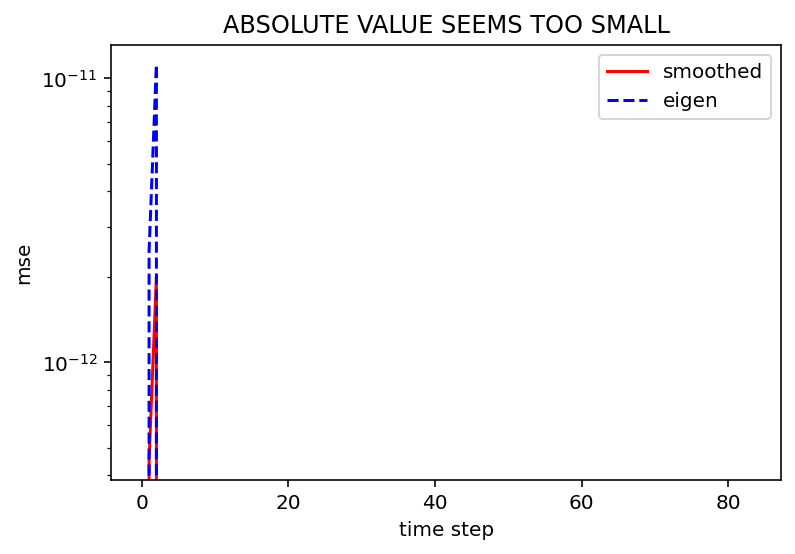

In [11]:
# MSE through time
plt.figure()
plt.plot(disp_residual_mse, "-r", label="smoothed")
plt.plot(disp_residual_mse_eigen, "--b", label="eigen")
plt.yscale("log")
plt.legend()
plt.xlabel("time step")
plt.ylabel("mse")
plt.title("ABSOLUTE VALUE SEEMS TOO SMALL")
plt.show()


# Plot for each time step

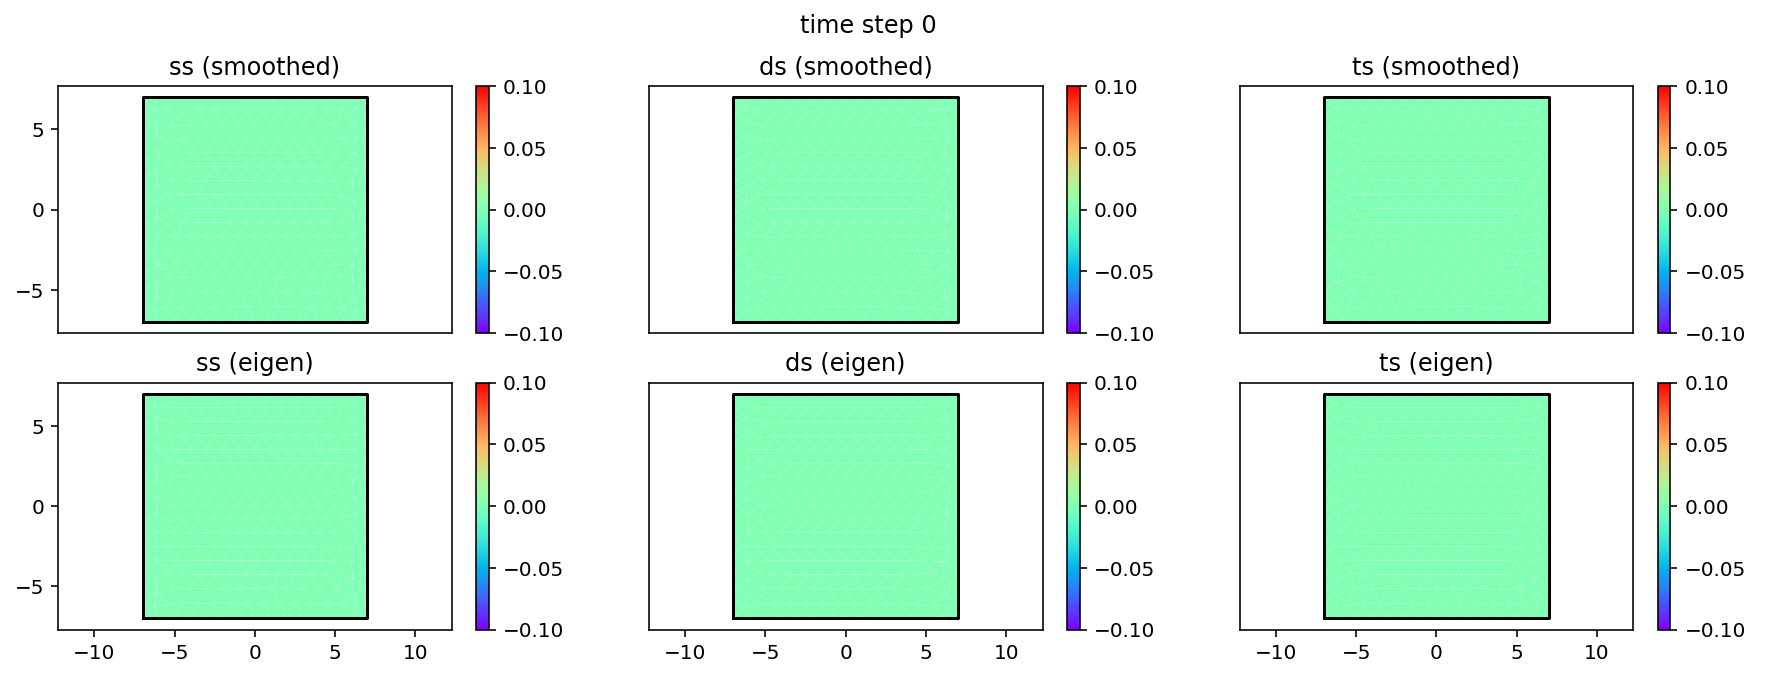

/Users/meade/mambaforge/envs/celeri/lib/python3.10/site-packages/matplotlib/quiver.py:689: RuntimeWarning: divide by zero encountered in double_scalars
  length = a * (widthu_per_lenu / (self.scale * self.width))
/Users/meade/mambaforge/envs/celeri/lib/python3.10/site-packages/matplotlib/quiver.py:689: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))


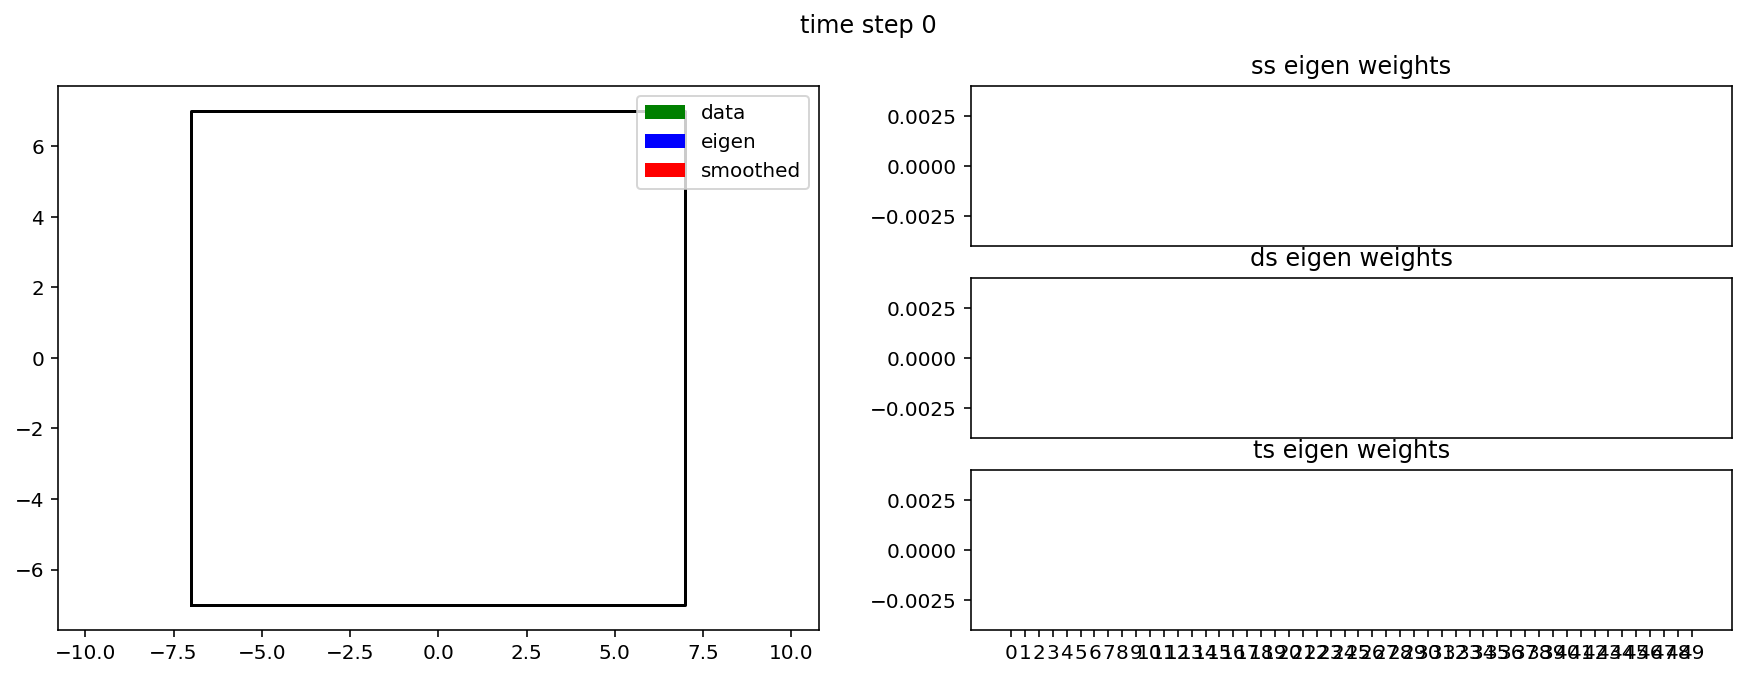

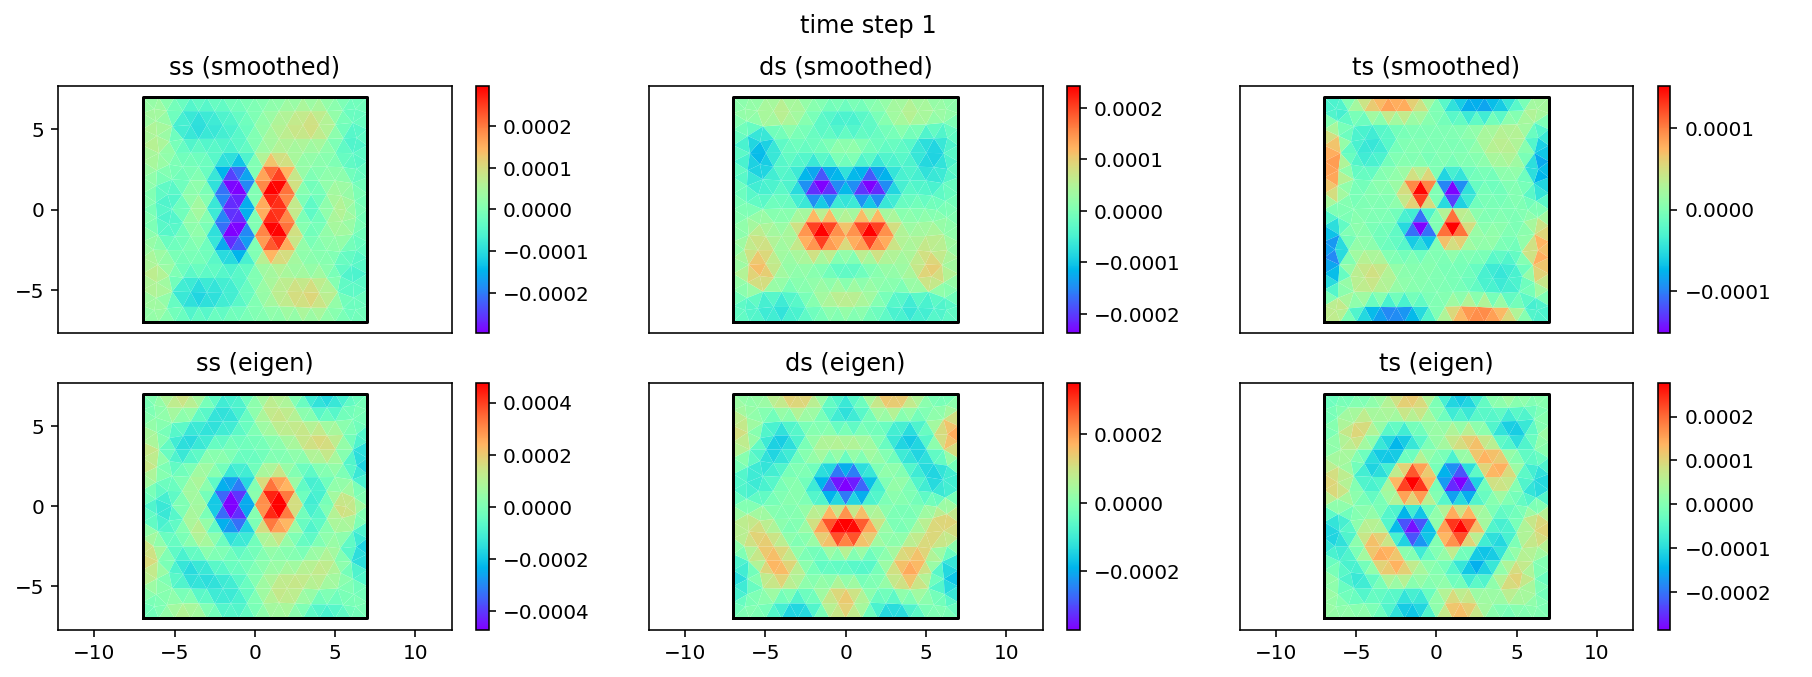

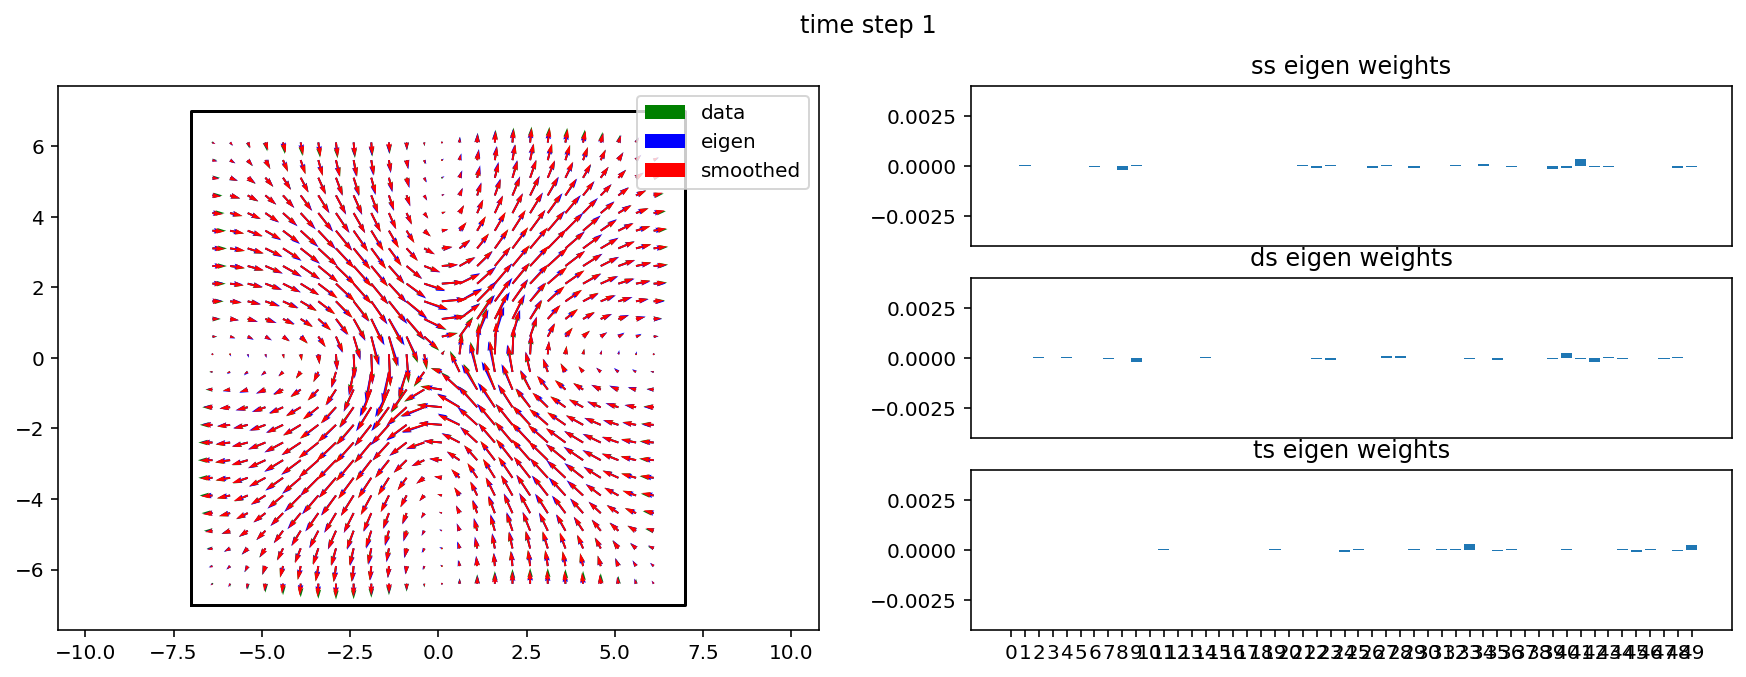

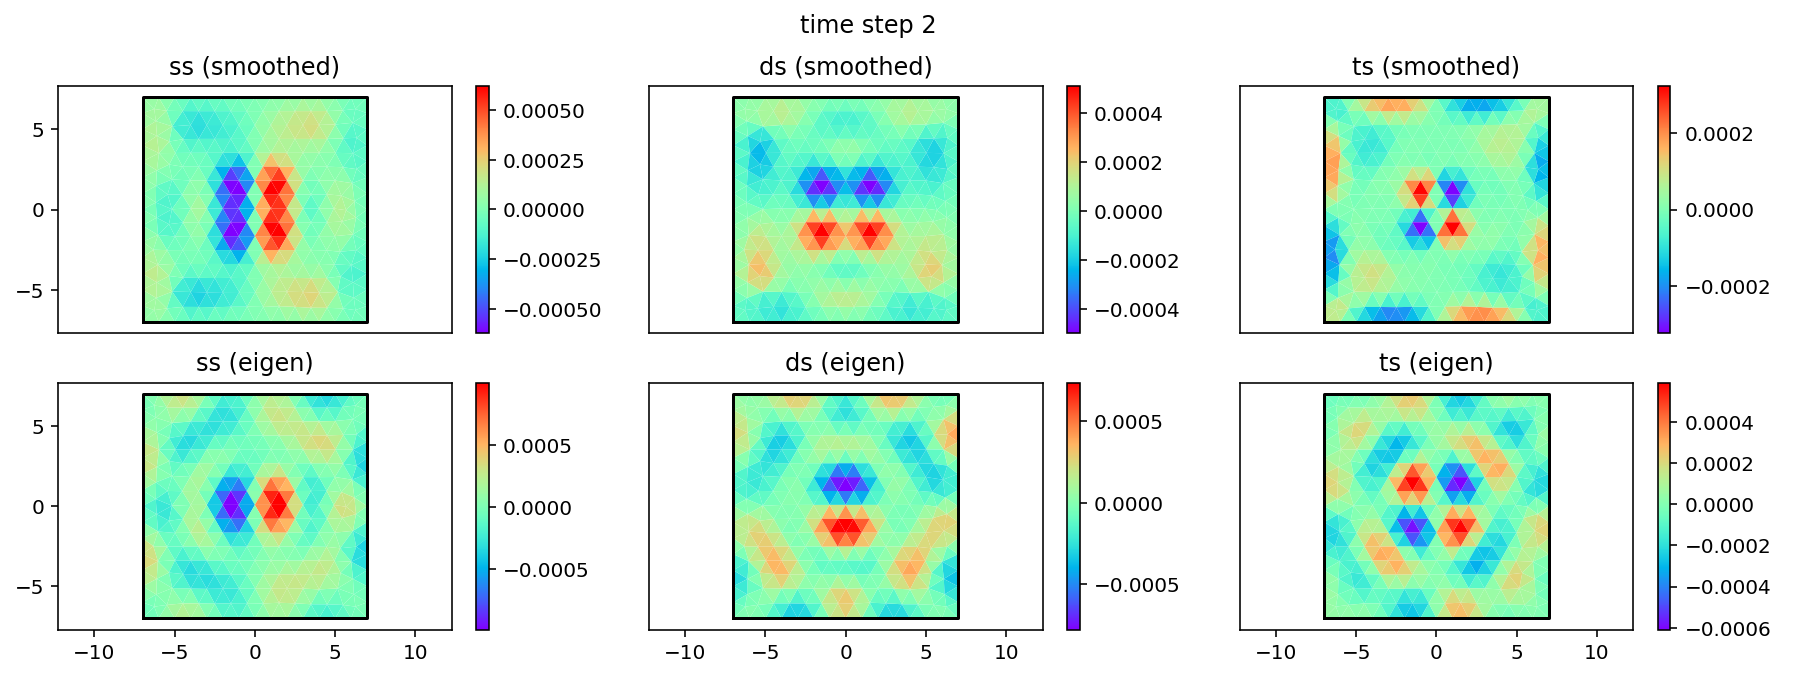

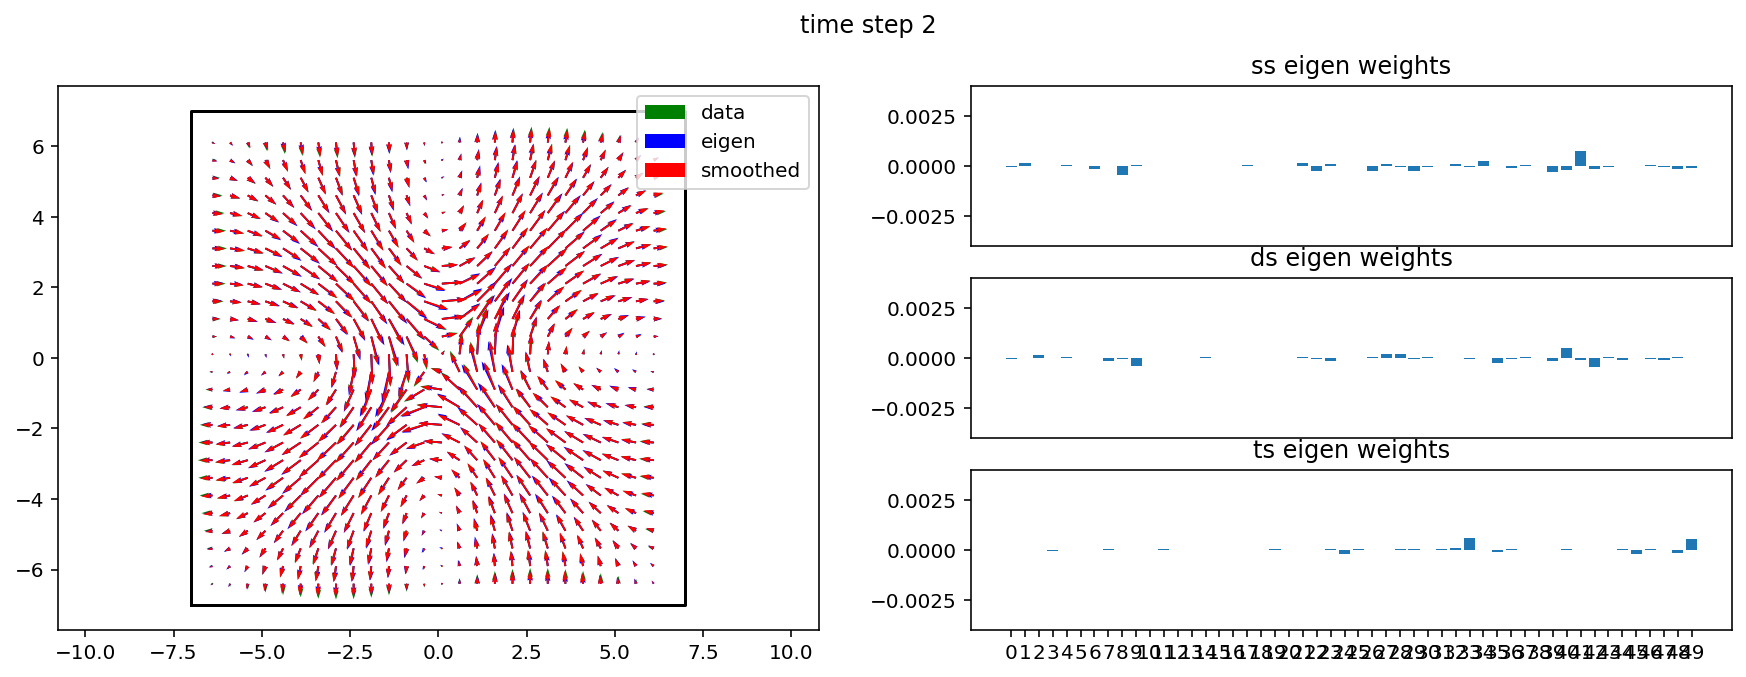

In [12]:
eigen_index = list(range(0, n_eigenvalues))
y_lim = (-0.004, 0.004)

# for i in range(len(n_disp_file_list)):
for i in range(3):
    plt.figure(figsize=(15, 5))
    plt.subplot(2, 3, 1)
    ax = plt.gca()
    plot_mesh(meshes[0], est_slip[3 * nsource_tri + 0 :: 3, i], ax)
    ax.plot([-7, 7, 7, -7, -7], [-7, -7, 7, 7, -7], "k")
    plt.xticks([])
    plt.axis("equal")
    plt.title("ss (smoothed)")

    plt.subplot(2, 3, 2)
    ax = plt.gca()
    plot_mesh(meshes[0], est_slip[3 * nsource_tri + 1 :: 3, i], ax)
    ax.plot([-7, 7, 7, -7, -7], [-7, -7, 7, 7, -7], "k")
    plt.axis("equal")
    plt.xticks([])
    plt.yticks([])
    plt.title("ds (smoothed)")

    plt.subplot(2, 3, 3)
    ax = plt.gca()
    plot_mesh(meshes[0], est_slip[3 * nsource_tri + 2 :: 3, i], ax)
    ax.plot([-7, 7, 7, -7, -7], [-7, -7, 7, 7, -7], "k")
    plt.axis("equal")
    plt.xticks([])
    plt.yticks([])
    plt.title("ts (smoothed)")

    plt.subplot(2, 3, 4)
    ax = plt.gca()
    plot_mesh(meshes[0], est_slip_eigen[3 * nsource_tri + 0 :: 3, i], ax)
    ax.plot([-7, 7, 7, -7, -7], [-7, -7, 7, 7, -7], "k")
    plt.axis("equal")
    plt.title("ss (eigen)")

    plt.subplot(2, 3, 5)
    ax = plt.gca()
    plot_mesh(meshes[0], est_slip_eigen[3 * nsource_tri + 1 :: 3, i], ax)
    ax.plot([-7, 7, 7, -7, -7], [-7, -7, 7, 7, -7], "k")
    plt.axis("equal")
    plt.yticks([])
    plt.title("ds (eigen)")

    plt.subplot(2, 3, 6)
    ax = plt.gca()
    plot_mesh(meshes[0], est_slip_eigen[3 * nsource_tri + 2 :: 3, i], ax)
    ax.plot([-7, 7, 7, -7, -7], [-7, -7, 7, 7, -7], "k")
    plt.axis("equal")
    plt.yticks([])
    plt.title("ts (eigen)")
    
    plt.suptitle(f"time step {i}")

    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    ax = plt.gca()
    plt.quiver(
        obsg[:, 0],
        obsg[:, 1],
        observed_disp[0::3, i],
        observed_disp[1::3, i],
        label="data",
        color="g",
    )
    plt.quiver(
        obsg[:, 0],
        obsg[:, 1],
        pred_disp_eigen[0::3, i],
        pred_disp_eigen[1::3, i],
        label="eigen",
        color="b",
    )
    plt.quiver(
        obsg[:, 0],
        obsg[:, 1],
        pred_disp_bjm[0::3, i],
        pred_disp_bjm[1::3, i],
        label="smoothed",
        color="r",
    )

    plt.legend()
    plt.plot([-7, 7, 7, -7, -7], [-7, -7, 7, 7, -7], "k")
    plt.axis("equal")
    plt.suptitle(f"time step {i}")

    plt.subplot(3, 2, 2)
    plt.bar(eigen_index, est_eigen[0::3, i])
    plt.title("ss eigen weights")
    plt.xticks([])
    plt.ylim(y_lim)

    plt.subplot(3, 2, 4)
    plt.bar(eigen_index, est_eigen[1::3, i])
    plt.title("ds eigen weights")
    plt.xticks([])
    plt.ylim(y_lim)

    plt.subplot(3, 2, 6)
    plt.bar(eigen_index, est_eigen[2::3, i])
    plt.title("ts eigen weights")
    plt.xticks(eigen_index)
    plt.ylim(y_lim)
    plt.show()


# Compare conditions numbers

In [13]:
print(f"Smoothed condition number: {np.linalg.cond(assembled_mat.T * weights.T @ assembled_mat):0.2f}")
print(f"Eigenmode condition number: {np.linalg.cond(eigen_to_disp):0.2f}")


Smoothed condition number: 3925.15
Eigenmode condition number: 127.44


In [14]:
# Pasted from celeri
# def get_tde_slip_rate_constraints(meshes, operators):
#     """Construct TDE slip rate constraint matrices for each mesh.
#     These are essentially identity matrices, used to set TDE slip
#     rates on elements lining the edges of the mesh, as controlled
#     by input parameters
#     top_slip_rate_constraint,
#     bot_slip_rate_constraint,
#     side_slip_rate_constraint

#     Args:
#         meshes (List): list of mesh dictionaries
#         operators (Dict): dictionary of linear operators
#     """
#     for i in range(len(meshes)):
#         # Empty constraint matrix
#         tde_slip_rate_constraints = np.zeros((2 * meshes[i].n_tde, 2 * meshes[i].n_tde))
#         # Top constraints
#         if meshes[i].top_slip_rate_constraint > 0:
#             # Indices of top elements
#             top_indices = np.asarray(np.where(meshes[i].top_elements))
#             # Indices of top elements' 2 slip components
#             top_idx = celeri.get_2component_index(top_indices)
#             tde_slip_rate_constraints[top_idx, top_idx] = 1
#         # Bottom constraints
#         if meshes[i].bot_slip_rate_constraint > 0:
#             # Indices of bottom elements
#             bot_indices = np.asarray(np.where(meshes[i].bot_elements))
#             # Indices of bottom elements' 2 slip components
#             bot_idx = celeri.get_2component_index(bot_indices)
#             tde_slip_rate_constraints[bot_idx, bot_idx] = 1
#         # Side constraints
#         if meshes[i].side_slip_rate_constraint > 0:
#             # Indices of side elements
#             side_indices = np.asarray(np.where(meshes[i].side_elements))
#             # Indices of side elements' 2 slip components
#             side_idx = celeri.get_2component_index(side_indices)
#             tde_slip_rate_constraints[side_idx, side_idx] = 1
#         # Eliminate blank rows
#         sum_constraint_columns = np.sum(tde_slip_rate_constraints, 1)
#         tde_slip_rate_constraints = tde_slip_rate_constraints[
#             sum_constraint_columns > 0, :
#         ]
#         operators.tde_slip_rate_constraints[i] = tde_slip_rate_constraints
#         meshes[i].n_tde_constraints = np.sum(sum_constraint_columns > 0)



In [15]:
# Eigenvectors to displacement operator
print(operators.tde_slip_rate_constraints[0].shape)
print(eigenvectors_three_component.shape)
print(tri_to_disp.shape)

eigen_to_tde_constraints = operators.tde_slip_rate_constraints[0] @ eigenvectors_three_component


(168, 1374)
(1374, 150)
(2028, 1374)
